In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
!pip install scikit-learn==1.4.1.post1


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

In [2]:
!mkdir AltStuff

#add data set

In [3]:
# Load the dataset
file_path = 'AltStuff/altitude_sickness_circulation.csv'
data = pd.read_csv(file_path)

In [4]:
# Define a function to check for hypertension or diabetes
def check_illness(row, illness_list):
    illnesses = row[['past_illness_i', 'past_illness_ii', 'past_illness_iii']].astype(str).tolist()
    return any(illness in illnesses for illness in illness_list)

# Create binary indicators for hypertension and diabetes
hypertension_list = ['hypertension', 'high blood pressure', 'HBP']
diabetes_list = ['diabetes', 'high blood sugar', 'HBS']
data['hypertension'] = data.apply(lambda row: check_illness(row, hypertension_list), axis=1).astype(int)
data['diabetes'] = data.apply(lambda row: check_illness(row, diabetes_list), axis=1).astype(int)

# Prepare the target variable based on Lake Louise Score (LLS)
data['AMS'] = np.where(data['lls_score'] >= 3, 1, 0)

# Define additional features
additional_features = ['ascent_day', 'smoking', 'sym_headache', 'sym_gi', 'sym_fatigue', 'sym_dizziness']

# Define selected features
selected_features = [
    'age', 'gender', 'permanent_altitude', 'bp_systolic', 'bp_diastolic',
    'spo2', 'pulse', 'hypertension', 'diabetes'
] + additional_features

# Extract selected features
X = data[selected_features]
y = data['AMS']

# Identifying categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


knn_classifier = KNeighborsClassifier()
param_grid_classifier = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search_classifier = GridSearchCV(knn_classifier, param_grid_classifier, cv=7, scoring='accuracy')
pipeline_classifier = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('grid_search', grid_search_classifier)])

# Split the data into training and test sets
X_train, X_test, y_train_class, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the model
pipeline_classifier.fit(X_train, y_train_class)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'permanent_altitude', 'bp_systolic', 'bp_diastolic', 'spo2',
       'pulse', 'hypertension', 'diabetes', 'ascent_day', 'smoking',
       'sym_headache', 'sym_gi', 'sym_fatigue', 'sym_dizziness'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender'], dtype='object'))])),
                ('grid_search',
                 GridSearchCV(cv=7, estimator=KNeighborsClassifier(),
                              param_grid={'metric': ['euclidean', 'manhattan'],
                                          'n_neighbors': [3, 5, 7, 10, 15, 20],
                                          'weights': ['uniform', 'distance']},
                              scoring='accuracy'))])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Function to create binary indicators for hypertension and diabetes
def check_illness(row, illness_list):
    illnesses = row[['past_illness_i', 'past_illness_ii', 'past_illness_iii']].astype(str).tolist()
    return any(illness in illnesses for illness in illness_list)

# Lists of illnesses
hypertension_list = ['hypertension', 'high blood pressure', 'HBP']
diabetes_list = ['diabetes', 'high blood sugar', 'HBS']

# Creating the binary indicators
data['hypertension'] = data.apply(lambda row: check_illness(row, hypertension_list), axis=1).astype(int)
data['diabetes'] = data.apply(lambda row: check_illness(row, diabetes_list), axis=1).astype(int)

# Define additional features
additional_features = ['ascent_day', 'smoking', 'sym_headache', 'sym_gi', 'sym_fatigue', 'sym_dizziness']
selected_features = [
    'age', 'gender', 'permanent_altitude', 'bp_systolic', 'bp_diastolic',
    'spo2', 'pulse', 'hypertension', 'diabetes'
] + additional_features

# Extract features and target variables
X = data[selected_features]
y_regression = data['lls_score'].fillna(data['lls_score'].mean())  # Target for regression, filling missing values

# Identifying categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Regression model setup
knn_regressor = KNeighborsRegressor()
param_grid_regressor = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search_regressor = GridSearchCV(knn_regressor, param_grid_regressor, cv=7, scoring='neg_mean_squared_error')
pipeline_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('grid_search', grid_search_regressor)])



# Split data for LLS regression
X_train_regress, X_test_regress, y_train_regress, y_test_regress = train_test_split(X, y_regression, test_size=0.3, random_state=0)

# Fit the regression model
pipeline_regressor.fit(X_train_regress, y_train_regress)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'permanent_altitude', 'bp_systolic', 'bp_diastolic', 'spo2',
       'pulse', 'hypertension', 'diabetes', 'ascent_day', 'smoking',
       'sym_headache', 'sym_gi', 'sym_fatigue', 'sym_dizziness'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender'], dtype='object'))])),
                ('grid_search',
                 GridSearchCV(cv=7, estimator=KNeighborsRegressor(),
                              param_grid={'metric': ['euclidean', 'manhattan'],
                                          'n_neighbors': [3, 5, 7, 10, 15, 20],
                                          'weights': ['uniform', 'distance']},
                              scoring='neg_mean_squared_error'))])

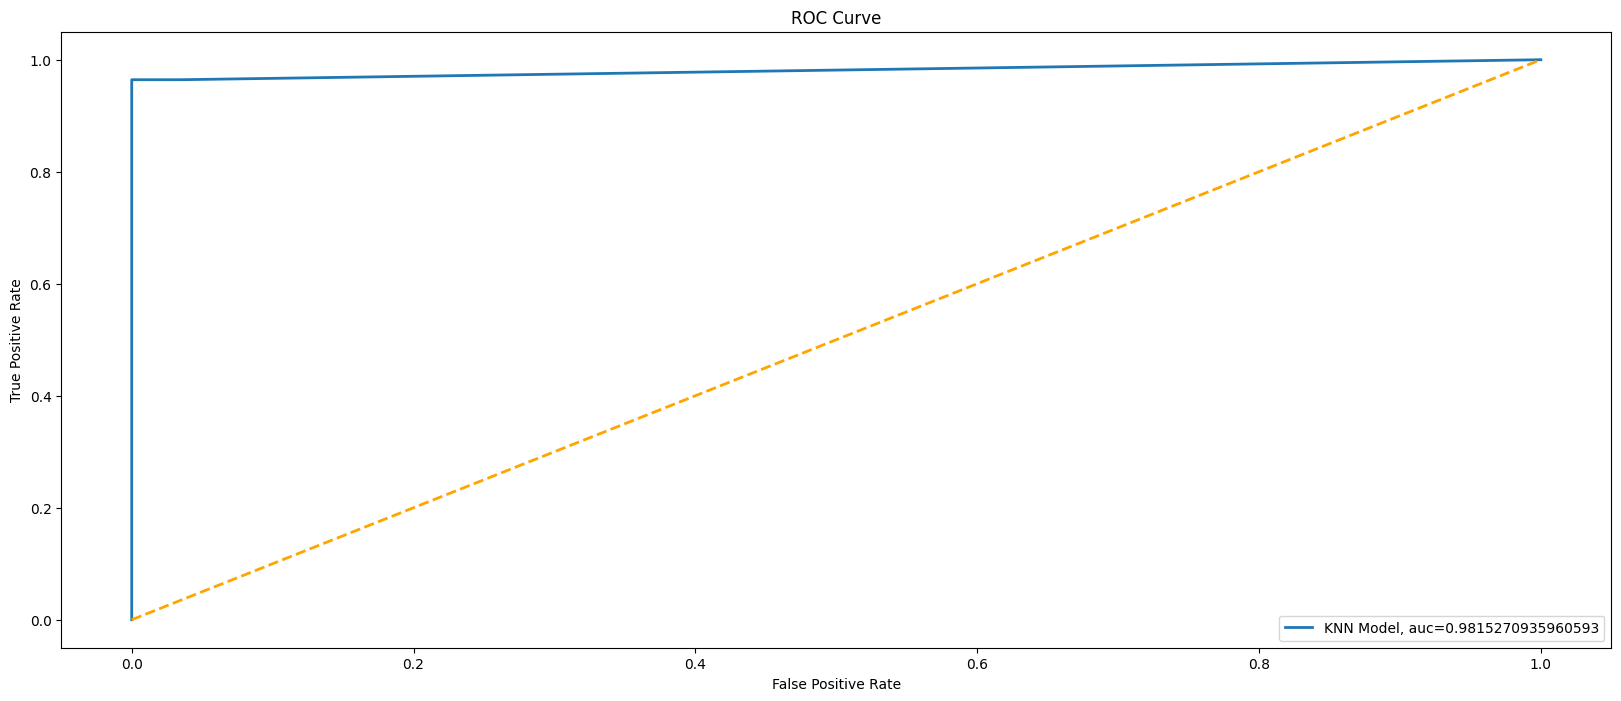

In [5]:
# For ROC Curve, you need probabilities of the positive class
y_pred_probs = pipeline_classifier.predict_proba(X_test)[:, 1]

# ROC Curve and AUC Score
plt.figure(figsize=(20, 8))
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
auc = roc_auc_score(y_test, y_pred_probs)
plt.plot(fpr, tpr, label="KNN Model, auc=" + str(auc), lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

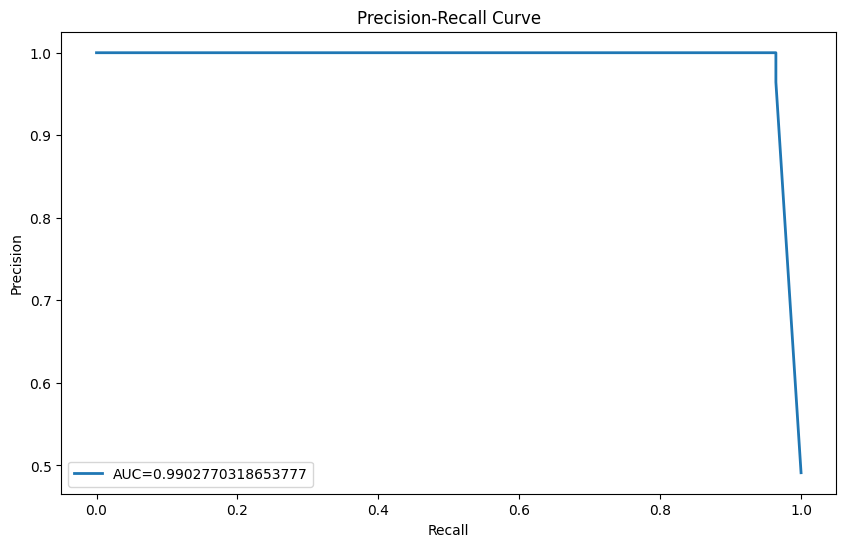

In [6]:
# Ensure your KNN model can return probabilities
# Note: Standard KNeighborsClassifier supports predict_proba method

# Predict probabilities for the positive class
y_pred_proba = pipeline_classifier.predict_proba(X_test)[:, 1]

# Now generate the Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_score = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label="AUC="+str(auc_score), lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


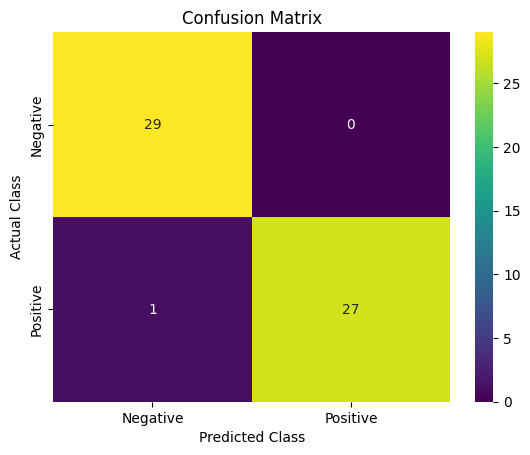

In [7]:
# Confusion Matrix
y_pred = pipeline_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, cmap='viridis', annot=True, fmt='g',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

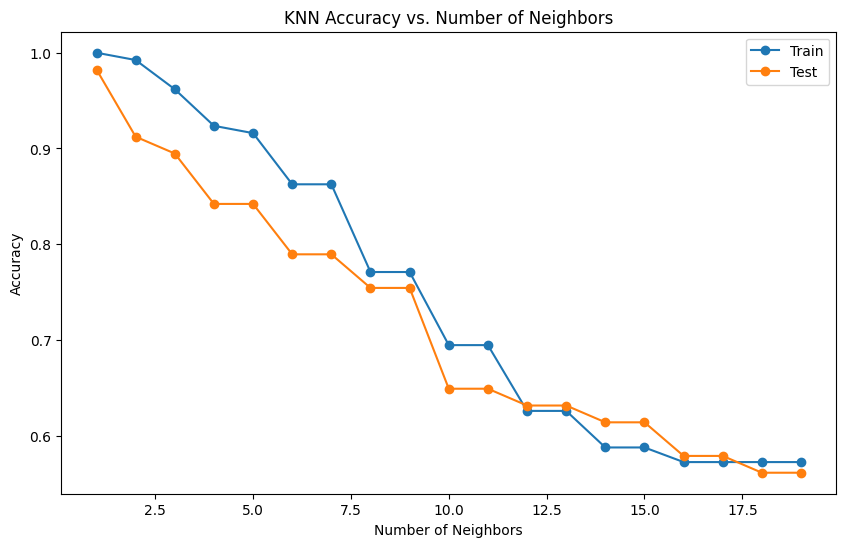

In [8]:
import matplotlib.pyplot as plt

neighbor_range = range(1, 20)  # or any range of n_neighbors you're interested in
train_scores, test_scores = list(), list()

# Assuming you have a preprocessor set up as before
for n in neighbor_range:
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('knn', KNeighborsClassifier(n_neighbors=n))])
    model.fit(X_train, y_train_class)

    train_scores.append(model.score(X_train, y_train_class))
    test_scores.append(model.score(X_test, y_test))


plt.figure(figsize=(10, 6))
plt.plot(neighbor_range, train_scores, label='Train', marker='o')
plt.plot(neighbor_range, test_scores, label='Test', marker='o')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
# Make predictions and evaluate the model
preds = pipeline_classifier.predict(X_test)
score = accuracy_score(y_test, preds)
report = classification_report(y_test, preds)

print("Accuracy:", score)
print("Classification Report:\n", report)


Accuracy: 0.9824561403508771
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       1.00      0.96      0.98        28

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57



In [10]:
import pickle

# Assuming 'pipeline' is your trained model
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(pipeline_classifier, file)

In [11]:
import pandas as pd

# Sample input data (replace with actual values later)
sample_data = {
    'age': [49],  # Age of the individual
    'gender': ['M'],  # Gender: 'M' for male, 'F' for female
    'permanent_altitude': [1],  # Altitude of permanent residence in meters
    'bp_systolic': [1350],  # Systolic blood pressure
    'bp_diastolic': [90],  # Diastolic blood pressure
    'spo2': [98],  # Blood oxygen saturation in percentage
    'pulse': [103],  # Pulse rate in beats per minute
    'hypertension': [1],  # 1 if the individual has hypertension, 0 otherwise
    'diabetes': [1],  # 1 if the individual has diabetes, 0 otherwise
    'ascent_day': [1],  # Number of days spent ascending to current altitude
    'smoking': [1],  # 1 if the individual smokes, 0 otherwise
    'sym_headache': [1],  # 1 if experiencing headache, 0 otherwise
    'sym_gi': [0],  # 1 if experiencing gastrointestinal distress, 0 otherwise
    'sym_fatigue': [0],  # 1 if experiencing fatigue, 0 otherwise
    'sym_dizziness': [1]  # 1 if experiencing dizziness, 0 otherwise
}

# Convert sample data to DataFrame
sample_input_df = pd.DataFrame(sample_data)

# Assuming your preprocessor and model pipeline (named 'pipeline') are already defined and trained

# Preprocess the sample input
processed_sample_input = pipeline_classifier.named_steps['preprocessor'].transform(sample_input_df)

# Get the probability of AMS risk
predicted_prob = pipeline_classifier.named_steps['grid_search'].best_estimator_.predict_proba(processed_sample_input)

# Output the probability for the positive class (assuming '1' represents high risk)
ams_risk_probability = predicted_prob[0][1] * 100  # Multiply by 100 to get a percentage

# Scale the probability to the LLS score range (0 to 12) and round to nearest whole number
scaled_lls_score = round(ams_risk_probability / 100 * 12)

print("Probability of high AMS risk:", ams_risk_probability, "%")
print("Approximated LLS score:", scaled_lls_score)


Probability of high AMS risk: 67.48918008580704 %
Approximated LLS score: 8
